**Note: Chương trình được viết và chạy trên Google Colab**

In [ ]:
pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [ ]:
import numpy as np
import pandas as pd

import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display
import warnings

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Ignore warnings.warn("PySoundFile failed. Trying audioread instead.") khi đọc file .mp3 từ librosa
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os

# Connect to GoogleDrive's folder
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Datasets'
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#workingDir = '/content/gdrive/MyDrive/Datasets'
print('Current working directory:', os.getcwd())

Current working directory: /content/gdrive/MyDrive/Datasets


# **I. Preprocessing & Feature extraction**

In [ ]:
fixed_duration = 5 
def loadAudio(audio_file, sampling_rate=48000):
    # Load audio file
    y_audio, sr = librosa.load(audio_file, sr=sampling_rate)
    duration_audio = librosa.get_duration(y_audio, sr=sr)

    # Stretch audio file (kéo dãn file audio)
    rate = duration_audio/fixed_duration
    y = librosa.effects.time_stretch(y_audio, rate=rate)
    return y, sr

# MFCC feature extraction
def audio2MFCC(audio_file, n_mfcc=13, plot=False):
    y, sr = loadAudio(audio_file)
    mfcc_vec = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if plot:
        plot_wave_MFCC(y, mfcc_vec)
    return mfcc_vec

# Plot MFCC wave
def plot_wave_MFCC(y, mfcc_vec):
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(y, sr=sr)
    plt.title('Wave plot')
    
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc_vec, x_axis='time')
    clb = plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

## Đọc thử 2 file audio và vẽ hình

In [ ]:
# Thử nghiệm hàm trên 2 file audio
audio1 = "audio_records/common_voice_vi_21833213.mp3"
audio2 = "audio_records/common_voice_vi_21833243.mp3"

In [ ]:
# Đoạn ghi âm file audio1
y, sr = loadAudio(audio1)
IPython.display.Audio(y, rate=sr)

In [ ]:
# Đoạn ghi âm file audio2
y, sr = loadAudio(audio2)
IPython.display.Audio(y, rate=sr)

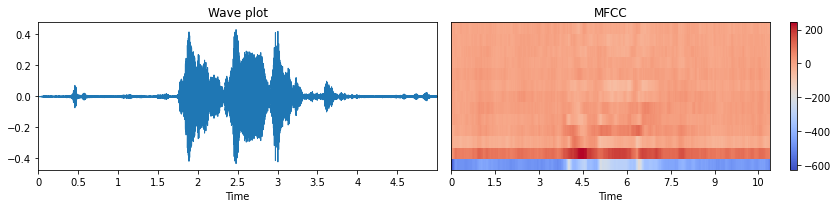

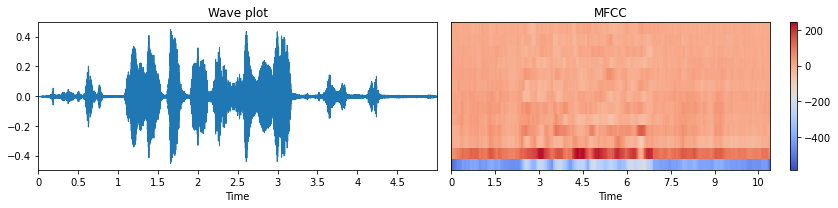

In [ ]:
mfcc1 = audio2MFCC(audio1, plot=True)
mfcc2 = audio2MFCC(audio2, plot=True)

## Đọc tất cả các file ghi âm

In [ ]:
drive_path = '/content/gdrive/MyDrive/Datasets'
audio_record_path = drive_path + '/audio_records'

In [ ]:
# Kết quả âm thanh vùng miền (accent) tương ứng với từng file ghi âm
df = pd.read_excel(drive_path + '/audio_record_details.xlsx')
display(df[['path', 'sentence', 'accents']])

,path,sentence,accents
0,common_voice_vi_28846908.mp3,Hương thu còn thoảng đâu đây bên thềm,South
1,common_voice_vi_26942577.mp3,Gió đông lạnh heo may về khắp lối.,North
2,common_voice_vi_25120501.mp3,Hay là do chúng ta không trùm khăn,South
3,common_voice_vi_26136615.mp3,Ngày em đi cất nhẹ gót quay về,South
4,common_voice_vi_27152897.mp3,Anh đã biết tình kia là không thể,North
...,...,...,...
1080,common_voice_vi_22714933.mp3,Qua ngày bốn mươi chín tôi sợ là không giúp đư...,South
1081,common_voice_vi_22714939.mp3,Hay là tay sai cho quỷ thì thực sự rất là khủn...,South
1082,common_voice_vi_22714940.mp3,Chợt mưa cái ào,South
1083,common_voice_vi_22714941.mp3,Bên trong đèn hồng đèn đỏ đèn xanh lờ mờ luôn ...,South


In [ ]:
# Tìm kiếm tất cả file record trong thư mục audio_records
mfcc_data = []
accent_label = []

n_test = df.shape[0]
count = 0
for filename in os.listdir(audio_record_path):
    filepath = audio_record_path + '/' + filename
    # Đọc file và trích xuất đặc trưng
    y, sr = loadAudio(filepath)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),axis=0)
    mfcc_data.append(mfcc)
    # Lấy thông tin vùng miền của file ghi âm
    df_row = df.loc[df['path'] == filename]
    accent = df_row['accents']
    accent_label.append(accent.values[0])

In [ ]:
X = np.array(mfcc_data)
y = np.array(accent_label)

In [ ]:
label = y
print(label)

['South' 'North' 'South' ... 'North' 'South' 'North']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check current dataset 
X_train[150:160]

array([[ 0.38645643,  1.6746365 ,  3.0608716 , ...,  0.8123226 ,
         1.0176356 ,  0.8976933 ],
       [-1.3018932 , -1.2483377 , -1.156813  , ...,  0.46769178,
         0.5301799 ,  0.64023304],
       [ 0.8719992 ,  0.62901235,  0.27368027, ...,  0.68559927,
         0.9333446 ,  0.96178746],
       ...,
       [ 0.7594959 ,  0.53185576,  0.19964941, ..., -0.5186645 ,
        -0.43400273, -0.26255327],
       [ 0.2962807 ,  0.13182808,  0.87882143, ...,  1.1725248 ,
         1.2232215 ,  1.1493313 ],
       [-1.7222755 , -1.6113752 , -1.4334385 , ..., -1.9266313 ,
        -1.8525523 , -1.7582394 ]], dtype=float32)

# **II. Huấn luyện mô hình và dự đoán**

## CNN (Convolutional Neural Network)

In [ ]:
# Encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train[:10]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape)

(759, 469, 1)


In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=8, padding = 'SAME',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(filters=64, kernel_size=8, padding = 'SAME'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size = 8))

model.add(Conv1D(filters=32, kernel_size=4, padding = 'SAME'))
model.add(Activation('relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding = 'SAME'))
model.add(Activation('relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding = 'SAME'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size = 4))

model.add(Flatten())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 469, 64)           576       
                                                                 
 activation (Activation)     (None, 469, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 469, 64)           32832     
                                                                 
 batch_normalization (BatchN  (None, 469, 64)          256       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 469, 64)           0         
                                                                 
 dropout (Dropout)           (None, 469, 64)           0         
                                                        

In [ ]:
# Training 
H = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/40
48/48 [==============================] - 6s 96ms/step - loss: 0.9712 - accuracy: 0.5296 - val_loss: 0.9751 - val_accuracy: 0.6043
Epoch 2/40
48/48 [==============================] - 4s 87ms/step - loss: 0.7757 - accuracy: 0.5810 - val_loss: 0.9205 - val_accuracy: 0.6166
Epoch 3/40
48/48 [==============================] - 4s 85ms/step - loss: 0.7289 - accuracy: 0.5903 - val_loss: 0.8229 - val_accuracy: 0.6227
Epoch 4/40
48/48 [==============================] - 4s 85ms/step - loss: 0.6944 - accuracy: 0.6430 - val_loss: 0.7817 - val_accuracy: 0.6534
Epoch 5/40
48/48 [==============================] - 4s 86ms/step - loss: 0.6928 - accuracy: 0.6996 - val_loss: 0.7343 - val_accuracy: 0.6779
Epoch 6/40
48/48 [==============================] - 4s 86ms/step - loss: 0.6419 - accuracy: 0.7246 - val_loss: 0.6727 - val_accuracy: 0.7025
Epoch 7/40
48/48 [==============================] - 4s 87ms/step - loss: 0.5821 - accuracy: 0.7563 - val_loss: 0.6798 - val_accuracy: 0.6626
Epoch 8/40
48

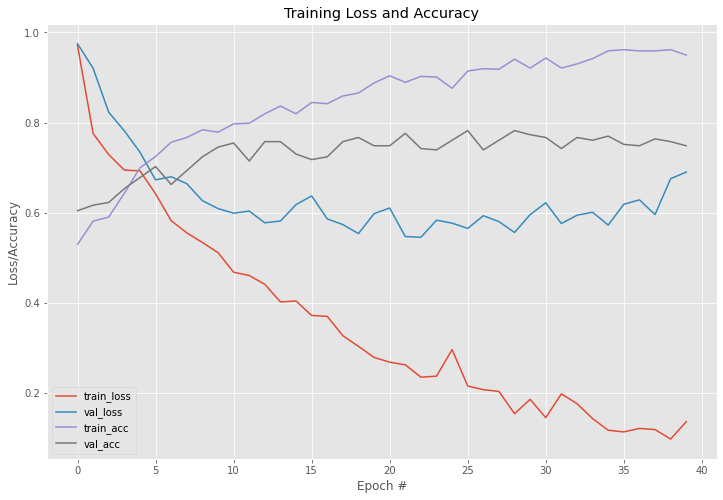

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred1 = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)

11/11 [==============================] - 1s 29ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1, target_names=[str(x) for x in lb.classes_]))

              precision    recall  f1-score   support

      Center       0.82      0.33      0.47        27
       North       0.75      0.88      0.81       197
       South       0.73      0.61      0.66       102

    accuracy                           0.75       326
   macro avg       0.77      0.61      0.65       326
weighted avg       0.75      0.75      0.74       326



## RNN (Recurrent Neural Network)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check current dataset 
X_train[150:160]

array([[ 0.86492765,  0.62612355,  0.20380598, ...,  1.1784981 ,
         1.3208448 ,  1.3181185 ],
       [-1.0853684 , -1.0665551 , -1.025364  , ..., -0.4963576 ,
        -0.8654974 , -1.3474759 ],
       [ 1.0074997 ,  0.7498631 ,  0.3597543 , ..., -0.03841802,
        -0.16332433, -0.1256856 ],
       ...,
       [-1.629619  , -1.5389149 , -1.3855642 , ..., -1.8938173 ,
        -1.8153262 , -1.7143341 ],
       [-0.24748918,  1.1113129 ,  1.4708916 , ...,  1.653684  ,
         1.6759547 ,  1.5520258 ],
       [ 0.497944  ,  0.3076153 ,  0.02251615, ..., -0.71443987,
        -0.6377561 , -0.52218544]], dtype=float32)

In [ ]:
# Encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
hidden_size = 200
batch_size = 32

timesteps = X_train.shape[1]
x_dim = 1

RNN = Sequential()
RNN.add(SimpleRNN(hidden_size,input_shape=(timesteps,x_dim)))
RNN.add(Dense(64,activation='relu'))
RNN.add(Dense(3,activation='softmax'))
RNN.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(RNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 200)               40400     
                                                                 
 dense_2 (Dense)             (None, 64)                12864     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 53,459
Trainable params: 53,459
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
RNN.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
H = RNN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
28/28 [==============================] - 7s 220ms/step - loss: 0.8481 - accuracy: 0.5714 - val_loss: 0.9044 - val_accuracy: 0.5392
Epoch 2/50
28/28 [==============================] - 6s 207ms/step - loss: 0.8832 - accuracy: 0.5772 - val_loss: 0.8161 - val_accuracy: 0.5945
Epoch 3/50
28/28 [==============================] - 7s 235ms/step - loss: 0.8946 - accuracy: 0.5933 - val_loss: 0.9562 - val_accuracy: 0.6267
Epoch 4/50
28/28 [==============================] - 7s 243ms/step - loss: 0.8793 - accuracy: 0.5864 - val_loss: 0.8497 - val_accuracy: 0.6221
Epoch 5/50
28/28 [==============================] - 6s 209ms/step - loss: 0.8809 - accuracy: 0.5899 - val_loss: 0.8463 - val_accuracy: 0.6175
Epoch 6/50
28/28 [==============================] - 6s 208ms/step - loss: 0.8629 - accuracy: 0.6002 - val_loss: 0.9304 - val_accuracy: 0.5714
Epoch 7/50
28/28 [==============================] - 6s 208ms/step - loss: 0.8876 - accuracy: 0.5887 - val_loss: 0.8565 - val_accuracy: 0.5806
Epoch 

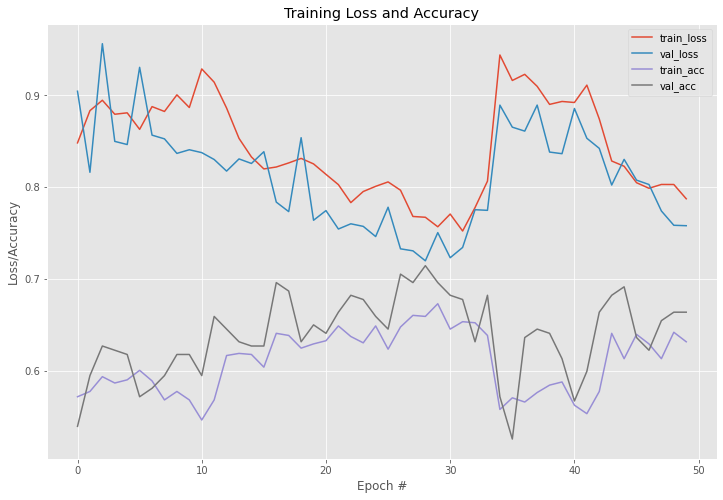

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
predictions = RNN.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in lb.classes_]))

2/2 [==============================] - 1s 248ms/step
              precision    recall  f1-score   support

      Center       0.00      0.00      0.00        18
       North       0.65      0.97      0.78       124
       South       0.75      0.32      0.45        75

    accuracy                           0.66       217
   macro avg       0.47      0.43      0.41       217
weighted avg       0.63      0.66      0.60       217

